# Introduction.


## An example of perceptual mapping: The car market

Principal Component Analysis (PCA) is a dimensionality reduction technique. It is extremely useful when we want to compress high dimensional correlated data into low dimensional orthogonal data. The methodology allows us to convert many correlated variables into fewer intuitive underlying components. PCA can then be used to visualize the position of the products/respondents on a two-dimensional map, called “perceptual maps”. PCA and perceptual maps have many uses in marketing analytics.

An important use of perceptual mapping is in brand positioning, where it is often used to understand how consumers perceive brands in their mind. Since much of marketing management is concerned with questions of positioning (With what brands do we compete? On what dimensions to we compete? Where should we position our brand?), perceptual mapping is an extremely useful technique for marketers.

In this handout, we will learn how to do PCA and generate perceptual maps using Python. These steps closely parallel what we did in the lecture.

## Overview of car ratings dataset
### Import the data and summarize it

We first import the data car-ratings.csv into a dataframe. As a reminder, remember to store the data in the same folder as your working directory. We can also take a look at the first few row of the data to see how it looks like.

In [2]:
import pandas as pd

# Read the CSV file into a DataFrame
car = pd.read_csv('data/car-ratings.csv')

# Display the first few rows of the DataFrame
car.head()

   Resp  Car No.     Car  Afford  Practical  Class  Sporty  Youth App  Fun
0     1        1  Taurus       4          6      4       3          2    2
1     1        2   Mazda       7          5      2       5          6    6
2     1        3   Camry       4          6      4       2          3    2
3     1        4   Acura       3          5      6       5          4    5
4     1        5     BMW       2          4      7       6          4    6


It is always a good idea to examine the summary statistics of the data using the describe command. It help us to see if we have any extreme values that would skew our results.

In [6]:
car.describe().round(2)

,Resp,Car No.,Afford,Practical,Class,Sporty,Youth App,Fun
count,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00
mean,10.50,3.50,3.46,5.00,3.96,3.88,4.00,4.25
std,5.79,1.71,2.07,1.56,1.89,1.97,1.64,1.79
min,1.00,1.00,1.00,2.00,1.00,1.00,2.00,2.00
25%,5.75,2.00,1.75,4.00,3.00,2.00,3.00,2.75
50%,10.50,3.50,3.50,5.00,3.00,4.50,4.00,4.00
75%,15.25,5.00,5.00,6.00,6.00,6.00,5.00,6.00
max,20.00,6.00,7.00,7.00,7.00,7.00,7.00,7.00


## Exploratory analysis

Now we want to do some simple analysis of the data. There are three key steps in the exploratory analysis.

### Exploratory step 1: Re-scale the data (1a)

In both exploratory analysis as well as the main PCA, it is important to scale the data to ensure that the data are comparable across individuals and samples. So for each ratings variable, we need to do the following: for each observation, we subtract the mean of that variable and divide by the standard deviation. This procedure is called z-scoring the data. In Python you can scale a variable using the scale() from sklearn.preprocessing package. We now scale the car ratings data using two steps. First, we create a new data frame called ‘car_scaled’ and copy car into it. Then we modify car_scaled by scaling columns 4 through 9. To confirm that the scaling was done correctly, we use the describe command.

In [11]:
from sklearn.preprocessing import scale

car_scaled = car.copy()
car_scaled.iloc[:, 3:9] = scale(car.iloc[:, 3:9]).round(3)
car_scaled.describe().round(2)

,Resp,Car No.,Afford,Practical,Class,Sporty,Youth App,Fun
count,120.00,120.00,120.00,120.00,120.00,120.00,120.00,120.00
mean,10.50,3.50,-0.00,0.00,0.00,0.00,-0.00,0.00
std,5.79,1.71,1.00,1.00,1.00,1.00,1.00,1.00
min,1.00,1.00,-1.19,-1.93,-1.57,-1.46,-1.23,-1.26
25%,5.75,2.00,-0.83,-0.64,-0.51,-0.95,-0.61,-0.84
50%,10.50,3.50,0.02,0.00,-0.51,0.32,0.00,-0.14
75%,15.25,5.00,0.75,0.64,1.08,1.08,0.61,0.98
max,20.00,6.00,1.72,1.29,1.62,1.59,1.84,1.54


Notice that the means of all the ratings variables are now zero and the standard deviations are all 1 now.

### Exploratory step 1: What is the correlation between the different car attributes? (1b)

Next we want to understand which attributes are correlated. Therefore, we examine the bivariate relationship between the variables. We can correlate each pair of variables one by one, but it is more informative and simpler to get a full matrix of correlations and order these correlations.

In [15]:
corr = car_scaled.iloc[:, 3:9].corr()
corr

,Afford,Practical,Class,Sporty,Youth App,Fun
Afford,1.000000,0.012946,-0.618241,-0.346061,-0.062018,-0.178413
Practical,0.012946,1.000000,-0.484328,-0.777632,-0.722101,-0.735533
Class,-0.618241,-0.484328,1.000000,0.798944,0.257621,0.573658
Sporty,-0.346061,-0.777632,0.798944,1.000000,0.636404,0.852368
Youth App,-0.062018,-0.722101,0.257621,0.636404,1.000000,0.643139
Fun,-0.178413,-0.735533,0.573658,0.852368,0.643139,1.000000


We can also visualize the correlation pictorially. To do that, we use the seaborn package.

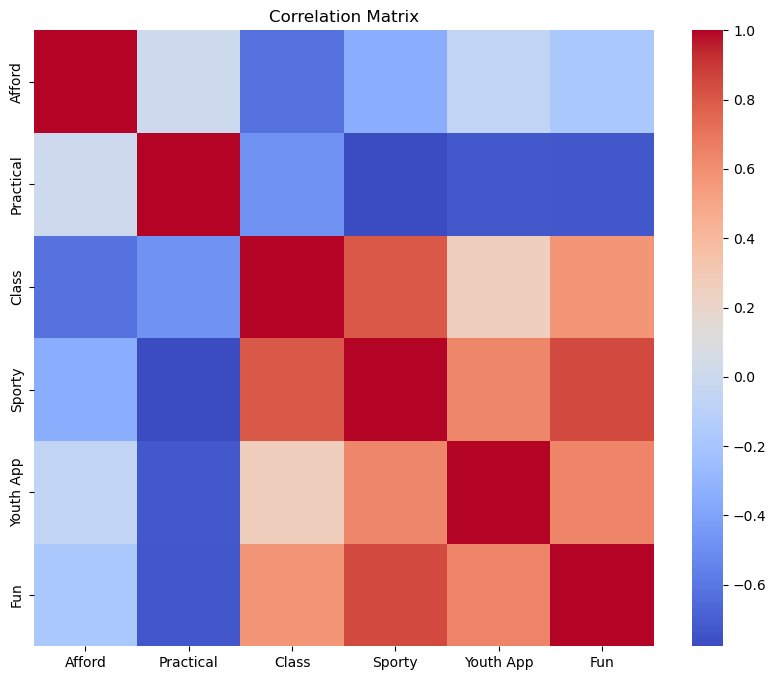

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = car_scaled.iloc[:, 3:9].corr()

# Plot the correlation matrix with labels
plt.figure(figsize=(10, 8))  # Set the figure size
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", 
            xticklabels=car.columns[3:9], yticklabels=car.columns[3:9])
plt.title('Correlation Matrix')
plt.show()

Together, the correlation analysis suggests that

1) there is a fair amount of correlation between different variables, and

2) some common themes emerge, e.g., classy cars are more likely to be thought of as sporty and fun and less likely to be thought of as practical or affordable.

### Exploratory step 1: Aggregate ratings by car brand (1c)

In [20]:
feature_mean = car_scaled.groupby("Car").mean().iloc[:, 2:9].round(2)
feature_mean

,Afford,Practical,Class,Sporty,Youth App,Fun
Car,,,,,,
Acura,-0.95,-0.32,1.22,0.95,0.31,0.42
BMW,-1.07,-0.64,1.35,1.21,0.46,1.26
Camry,-0.10,0.64,-0.51,-0.95,-0.61,-0.98
Mazda,1.35,-1.45,-0.51,0.57,1.38,0.98
Taurus,0.02,0.64,-0.64,-0.57,-0.61,-0.70
Volkswagen,0.75,1.13,-0.91,-1.21,-0.92,-0.98


This table gives us some insight into the broad perceptions about brands. For instance, BMW is perceived to be the least affordable, but most classy, sporty, and fun. Mazda Miata scores highly on affordability and youth appeal, but low on practicality. What other insights do you find?

We can examine these results using a heatmap to process these results better. You can again use the seaborn package.

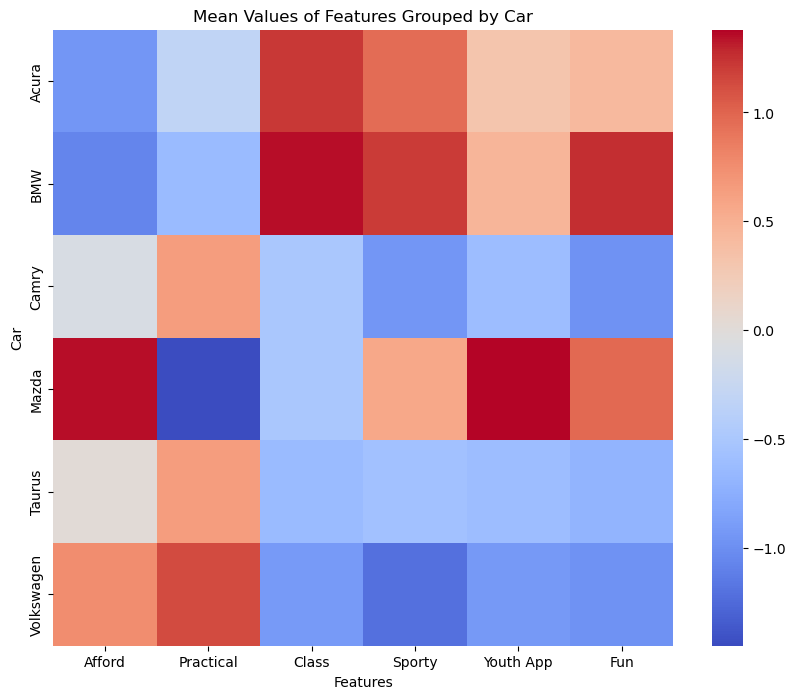

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(feature_mean, annot=False, cmap='coolwarm', 
            xticklabels=feature_mean.columns, yticklabels=feature_mean.index)
plt.title('Mean Values of Features Grouped by Car')
plt.xlabel('Features')
plt.ylabel('Car')
plt.show()

This heatmap is quite informative – it suggests that car brands BMW, Acura, and Mazda Miata are similar with high ratings on Fun, Classy, and Sporty. Taurus and Camry are also somewhat similar with high ratings on affordability and practicality and low ratings on fun and sportiness.

While this heatmap is great for giving us an overview of similarities and dissimilarities between various brands, it has three drawbacks

 1) it becomes increasingly cumbersome as the number of brands and attributes increas

 2) we still have to spend some effort to manually figure out which brands are similar on which attribute

 3) most importantly, it hasn’t reduced the dimensionality of the problem.


## Step 2: Principal Component Analysis

PCA will address all the problems outlined above. It is a statistical procedure to reduce the dimensionality of correlated data. The results from PCA can then be plotted on a perceptual map to help us understand the positioning of different brands.

### Perform PCA (2a)

Performing PCA in Python is quite simple. You can also check how much varition each variable explains.

In [28]:
from sklearn.decomposition import PCA

# Assuming car_scaled is your scaled DataFrame

features = car_scaled.iloc[:, 3:9]
pca = PCA()
pca.fit(features)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = pca.explained_variance_ratio_.cumsum()
eigenvalues = pca.explained_variance_
components = pca.components_

# Create a summary DataFrame
pca_summary = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})

# Display the summary DataFrame
pca_summary.transpose()

,0,1,2,3,4,5
Principal Component,PC1,PC2,PC3,PC4,PC5,PC6
Explained Variance,0.622225,0.223065,0.077372,0.042638,0.02523,0.00947
Cumulative Variance,0.622225,0.84529,0.922662,0.9653,0.99053,1.0


PCA maps our original six variables on another six-dimensional space, where each dimension is orthogonal. The second row of the table above tells us how much of the variance in the data is explained by each component, in decreasing order. Thus, the first component explains 62.23% of the variance in the data, the second component explains 22.30%, and so on. The third row denotes the cumulative variance. In our example, the first and second components explain 84.53% of the variance in the data. In other words, we can reduce the dimensionality of our original set of six variables to two, and still retain 84.53% of the explanatory power. 

### Derive relationship between the new factors and original attributes (2b)

The above table does not tell us how the factors generated by the PCA relate to the original attributes. To get that information, we use the following command.

In [32]:
# Get the PCA components (loadings)
pca_loadings = pca.components_.T  # Transpose to get features as rows

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(data=pca_loadings, 
                           columns=[f'PC{i+1}' for i in range(pca_loadings.shape[1])], 
                           index=features.columns)

# Display the loadings matrix
loadings_df.transpose()

,Afford,Practical,Class,Sporty,Youth App,Fun
PC1,-0.194748,-0.439281,0.400688,0.499573,0.382964,0.460782
PC2,0.726951,-0.317545,-0.457385,-0.042958,0.375429,0.136797
PC3,-0.525618,0.106216,-0.361478,-0.195483,0.713086,-0.187275
PC4,-0.040825,0.575951,-0.274703,0.037085,-0.043604,0.766730
PC5,-0.381754,-0.600793,-0.417854,-0.278940,-0.408884,0.271506
PC6,-0.099692,0.047366,-0.499517,0.794472,-0.186579,-0.268892


### Decide how many factors to keep (2c)

Now that we know the relationship between the new components or factors and the old original attributes and have some intuitive interpretation of the factors, we need to figure out how many factors to keep. Recall that dimensionality reduction was one of the main goals. If we retain all the six components, we have not reduced the size of the data at all. We can use the following to help us with this decision.

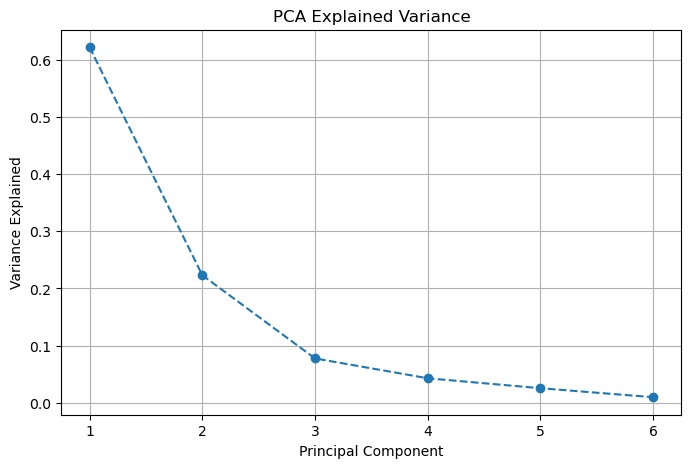

In [35]:
# Plot the explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('PCA Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

The common rule of thumb is to keep factors that are above the “kink” in the scree-plot. Here, that would translate to two factors. The second criteria often used is to keep factors which are over 1 in the scree plot. This criteria also gives us two factors in this case. Thus, we can reduce the dimensionality of our data from six to two in this example.

### Name the factors (2d)

Can we now think of intuitive names for the two factors? Naming factors is driven by your managerial intuition and domain knowledge. For example, in this case, can we name: PC1 = Style or Fashion and PC2 = Economy? The main idea is that one factor seems to be heavily correlated with the car’s image and coolness factor, whereas the other seems most positively correlated with affordability of the car and negatively correlated with image attributes like class.

### Plot the data on the two top factors and interpret (2f)

First we need to save the transformed features into a new dataset. 

#### Predict the new factor scores

We first generate a new dataset where the ratings are now transformed to the new factors using the following two steps. First, we use the command transform, which takes the results of our PCA and applies it to original features. Then, we create a new dataframe with new factors and assign the car names as well. We can check the generated dataset with the head() command.

In [41]:
pca_features = pca.transform(features)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_features, columns=[f'PC{i+1}' for i in range(pca_features.shape[1])])

# Add the 'Car' column for labeling
pca_df['Car'] = car_scaled['Car'].values
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Car
0,-1.597113,-0.636015,-0.628424,-0.575645,-0.212831,0.206819,Taurus
1,0.455035,2.294578,0.051320,0.935026,-0.615347,0.311633,Mazda
2,-1.616638,-0.384011,-0.091801,-0.621251,-0.321497,-0.311940,Camry
3,0.957539,-0.624615,-0.466139,0.054255,-0.414263,-0.177799,Acura
4,2.060131,-0.962320,-0.675667,0.005863,-0.054656,-0.171741,BMW


Now, we can plot the ratings on the two main principal components using the following code

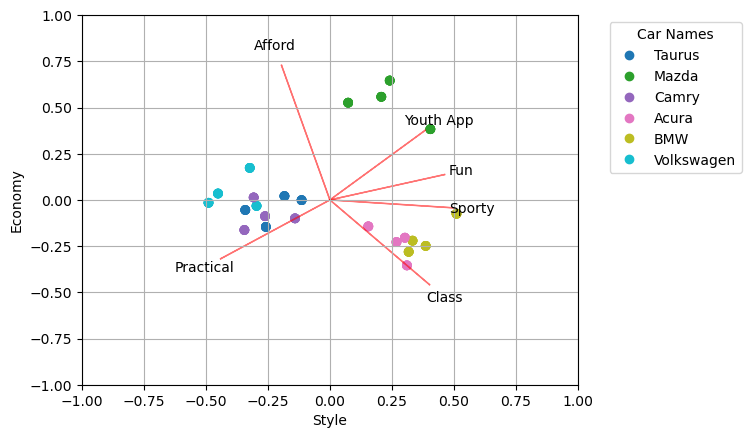

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def biplot(score, coeff, df, labels=None):
    xs = score.iloc[:, 0]
    ys = score.iloc[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    
    # Factorize the 'Car' column to get unique labels and indices
    point_labels, unique_cars = pd.factorize(df['Car'])
    
    # Define a colormap using the updated method
    colormap = plt.colormaps['tab10']
    
    # Assign colors to each car label
    colors = colormap(np.linspace(0, 1, len(unique_cars)))
    
    # Create a scatter plot with colors based on point_labels
    scatter = plt.scatter(xs * scalex, ys * scaley, c=point_labels, cmap=colormap)

    # Create a legend using the unique car names and their corresponding colors
    handles = [plt.Line2D([0], [0], marker='o', color=colors[i], linestyle='', label=car) for i, car in enumerate(unique_cars)]
    plt.legend(title='Car Names', handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    for i in range(n):
        plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='b', ha='center', va='center')
        else:
            plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='black', ha='center', va='center')

    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.xlabel("Style")
    plt.ylabel("Economy")
    plt.grid()

# Call the function. Use only the 2 PCs and pass the complete DataFrame.
# Assuming pca_df and car are previously defined DataFrames
biplot(pca_df.iloc[:, 0:2], np.transpose(pca.components_[0:2, :]), pca_df, car.columns[3:])
plt.show()


This map tells us that Youth.App, Fun, and Sportiness are highly correlated attributes and they cluster together in this graph. Class is similar to these attributes, but sufficiently different. The remaining two attributes, affordability and practicality, are close to orthogonal and different from each other as well as other attributes.

## Step 3: Positioning Maps

Next, we consider the question of positioning of cars. While the previous analysis tells us the relationship between various car attributes, and allowed us to compress many correlated attributes into fewer intuitvely meaningful attributes, it did not give us any insights into the positioning of cars. To understand how cars are positioned in the minds of consumers, we need to do augment the previous analysis a bit.

### Aggregate the scores across car brands (3a)

Now, we aggregate this new dataset and get the mean ratings of each car on the new factors. We use the same commande we used earlier in this document.

In [49]:
pca_mean = pca_df.groupby("Car").mean().round(2)
pca_mean.transpose()

Car,Acura,BMW,Camry,Mazda,Taurus,Volkswagen
PC1,1.60,2.39,-1.63,1.43,-1.39,-2.41
PC2,-1.01,-0.90,-0.37,2.30,-0.20,0.17
PC3,-0.02,-0.14,0.24,0.01,0.10,-0.18
PC4,-0.14,0.29,-0.25,-0.04,0.01,0.11
PC5,-0.23,0.05,0.12,0.11,0.09,-0.14
PC6,0.06,-0.06,-0.09,-0.01,0.20,-0.09


### Plot the positioning map (3b)

We take the means of car ratings for the first two factors and plot them on a two-dimensional plot to generate the positioning map.

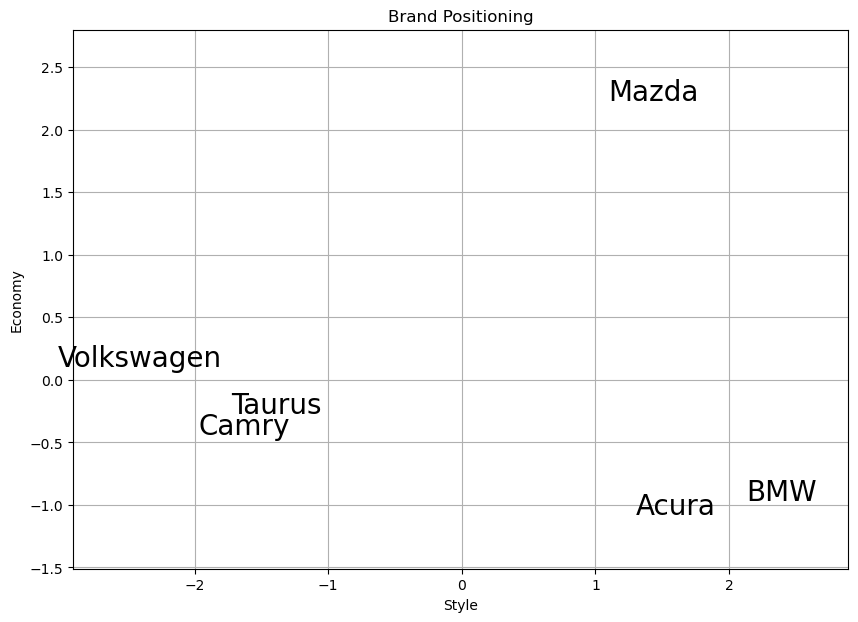

In [69]:
def plot_positioning_map(df, xlabel, ylabel):
    xs = df.iloc[:, 0]
    ys = df.iloc[:, 1]

    # Plot the car names at their corresponding positions
    plt.figure(figsize=(10, 7))
    
    # Annotate each point with the corresponding car name without the scatter plot
    for i in range(len(df)):
        plt.text(xs.iloc[i], ys.iloc[i], df.index[i], fontsize=20, ha='center', va='center')
    
    # Set the plot limits to ensure all names are within the figure box
    plt.xlim(xs.min() - 0.5, xs.max() + 0.5)
    plt.ylim(ys.min() - 0.5, ys.max() + 0.5)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("Brand Positioning")
    plt.grid()
    plt.show()

plot_positioning_map(pca_mean, "Style","Economy")

The perceptual map can now used for many important branding, positioning, and product design tasks. E.g., if you were to update your car brand, which attributes should you add or focus on? If you are introducing a new car brand, where would you position yourself? Are there any open areas available for entry?